In [1]:
# https://pypi.python.org/pypi/pydot
#!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica.  tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta
desde un lugar en particular y devolverla en un luar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro.
Para ello se nos facilita un archivo [csv](https://drive.google.com/open?id=1gTcb3WZ27DU0nMdvoyPBMYRFK8LU8-rt) donde aparecen el número de bicicletas contratadas
todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de  capturar la relación entre características y
número de bicicletas contratadas en un modelo.

## Carga de Datos


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving bikes.csv to bikes.csv
User uploaded file "bikes.csv" with length 54187 bytes


En el fichero CSV, como se ha mencionado, están incluidas las variables metereológicas diarias y el número de bicicletas contratadas.


In [3]:
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
bikes.head()

,date,temperature,humidity,windspeed,count
0,2011-01-03,2.716070,45.715346,21.414957,120.0
1,2011-01-04,2.896673,54.267219,15.136882,108.0
2,2011-01-05,4.235654,45.697702,17.034578,82.0
3,2011-01-06,3.112643,50.237349,10.091568,88.0
4,2011-01-07,2.723918,49.144928,15.738204,148.0


## Exploración

Los **histogramas** agrupan los datos en ubicaciones  y proporcionan un recuento de los  número de observaciones en cada caso. Sirven para identificar la distribución de los datos, y es posible que nos permita también identificación valores atípicos.

Un **gráfico de dispersión** (ScatterPlot) muestra la relación entre dos
variables como puntos en dos  dimensiones, un eje por cada atributo
Las gráficas de dispersión son útiles para detección de relaciones estructuradas
entre variables

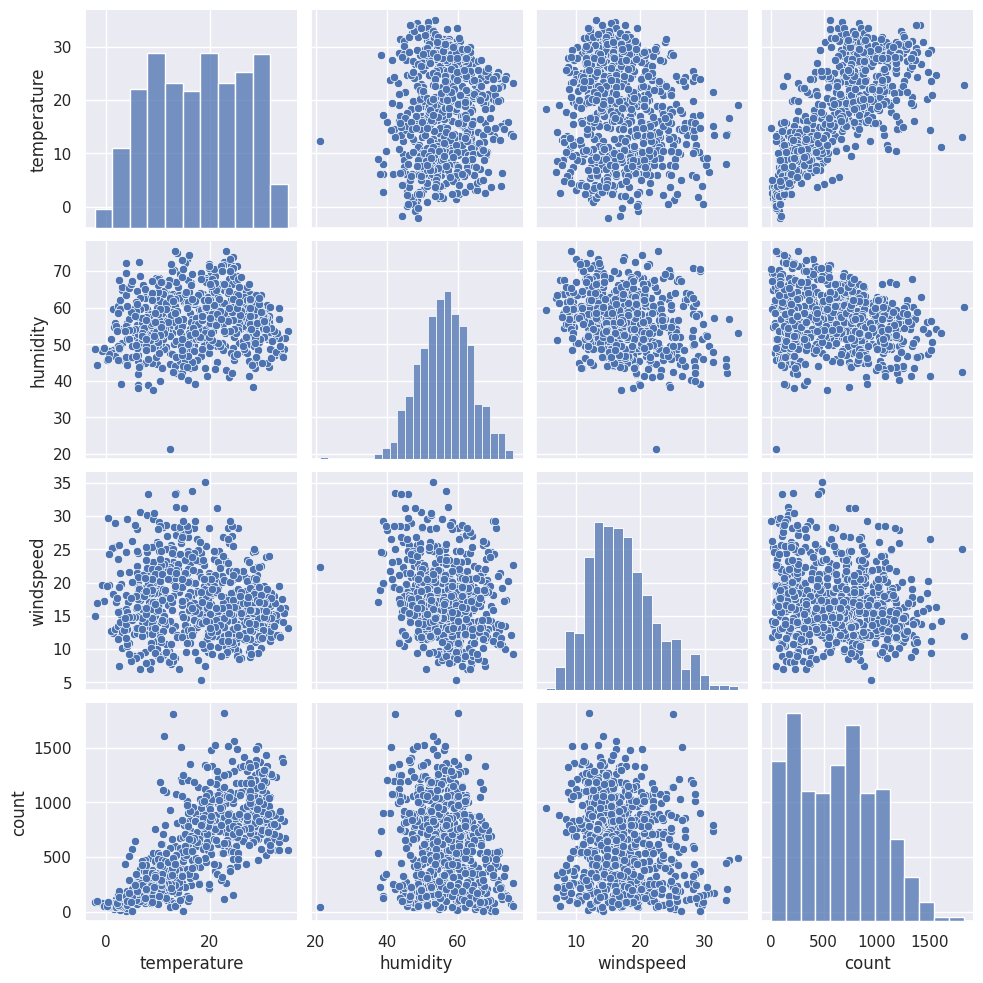

In [4]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.pairplot(bikes);

## Árboles de Decisión

Los árboles de decisión son una técnica basada en reglas.  La predicción se realiza aplicando una cascada de reglas del tipo "¿es la
temperatura es menor o igual a x grados?". Esto hace que el modelo sea fácil de interpretar.

Algunas de sus ventajas son las siguientes:
* No requiere ninguna transformación de datos. Significa que no tenemos que dedicar más tiempo
preprocesamiento de los datos.
* Puede manejar relaciones complejas (no sólo relaciones lineales simples).

**Parameters**

* *criterion*: La función para medir la calidad de una división (mse, mae, friedman_mse)
* *max_depth*: Profundidad máxima del árbol. (los valores bajos evitan el sobreajuste)



### Modelo con una sola variable


In [5]:
#1.1 Model Parametrization
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
#splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=2, random_state=0)

In [6]:
#1.2 Model construction
#regressor.fit(bikes[['temperature', 'humidity', 'windspeed']], bikes['count'])
# one feature predictor
regressor.fit(bikes[['temperature']], bikes['count'])

DecisionTreeRegressor(max_depth=2, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


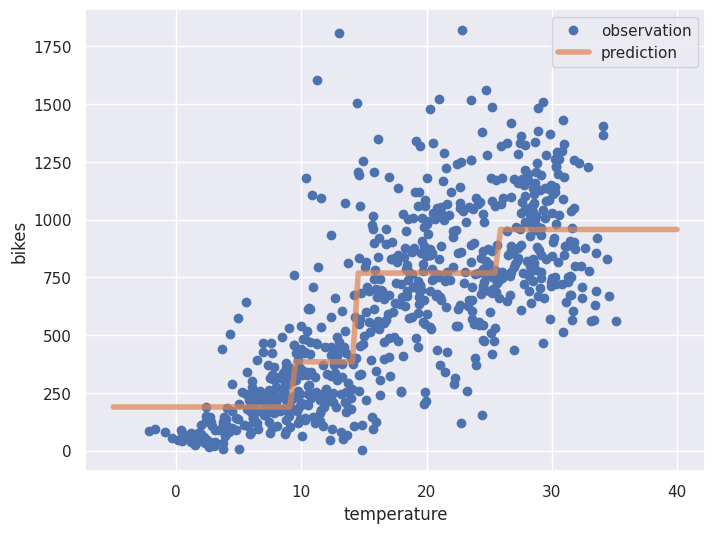

In [7]:
# 2.2 Model Plot
import matplotlib.pyplot as plt

import numpy as np
xx = np.linspace(-5, 40, 100)

plt.figure(figsize=(8,6))
plt.plot(bikes['temperature'], bikes['count'], 'o', label='observation')
plt.plot(xx, regressor.predict(xx.reshape(-1, 1)), linewidth=4, alpha=.7, label='prediction')
plt.xlabel('temperature')
plt.ylabel('bikes')
plt.legend()
plt.show()

Las reglas se organizan en un árbol binario: cada vez que se pide estimar el número de bicicletas contratadas se comprueba la temperatura con
las reglas empezando por la raíz del árbol hasta el final siguiendo el camino dictado por el resultado de las reglas.

Por ejemplo,

* si la temperatura de entrada es 16,5, la primera comprobación (temperatura <= 14,3)
nos dará un resultado negativo que nos llevará a su nodo hijo derecho

* El siguiente nivel del árbol (temperatura <= 25,8), esta vez tendrá una
respuesta positiva y terminará en su hijo izquierdo.

* Este nodo es una hoja, lo que significa que no contiene una regla sino el valor
que se quiere predecir. En este caso, predice 769 bicicletas.

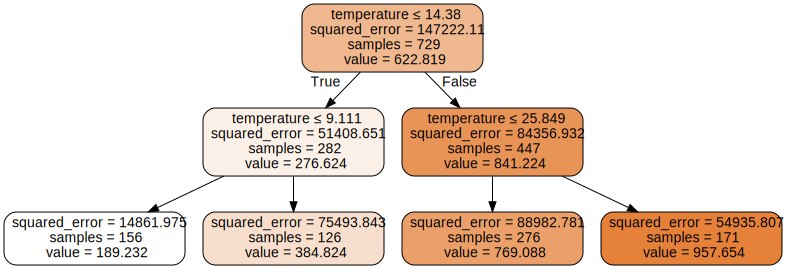

In [8]:
# Visualizar un árbol de decisión

import graphviz
from sklearn.tree import export_graphviz

# Crear un archivo DOT que representa el árbol de decisión (en este caso se devuelve como cadena)
dot_data = export_graphviz(regressor, out_file=None,
                           feature_names=["temperature"],
                           filled=True, rounded=True, special_characters=True)

# Generar el gráfico del árbol de decisión desde el archivo DOT
graph = graphviz.Source(dot_data)

# Mostrar el gráfico en Jupyter Notebook o en un archivo
#graph.view("arbol_de_decision")  # Esto guardará el gráfico en un archivo llamado "arbol_de_decision.pdf"
display(graph)

### Modelo basado en dos características

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


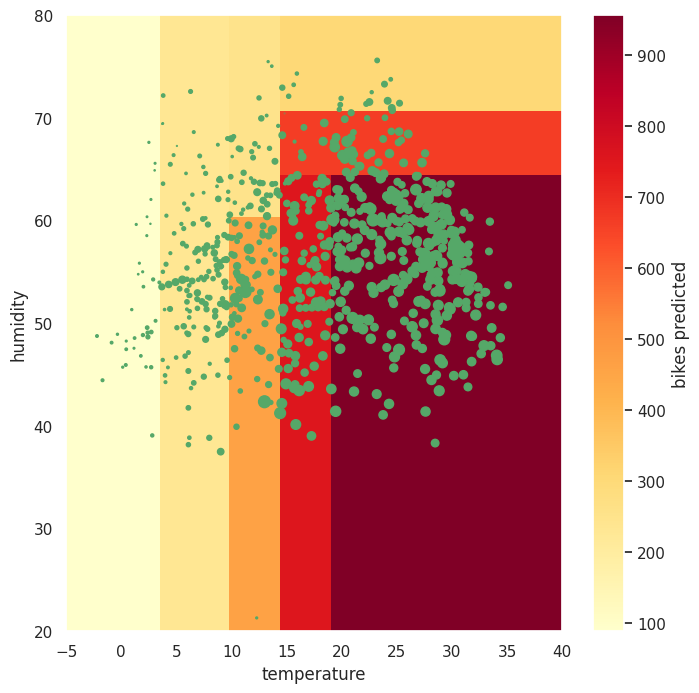

In [9]:
#1.1 Model Parametrization
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
#splitter: best/random
# max_depth: low value avoid overfitting
regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=3, random_state=0)
#1.2 Model construction
regressor.fit(bikes[['temperature', 'humidity']], bikes['count'])

# This visualization is only useful for a model of two predictors

nx = 30
ny = 30
# creating a grid of points
x_temperature = np.linspace(-5, 40, nx)
y_humidity = np.linspace(20, 80, ny)
xx, yy = np.meshgrid(x_temperature, y_humidity)
# evaluating the regresson on all the points
z_bikes = regressor.predict(np.array([xx.flatten(), yy.flatten()]).T)
zz = np.reshape(z_bikes, (nx, ny))


fig = plt.figure(figsize=(8, 8))
# plotting the predictions
plt.pcolormesh(x_temperature, y_humidity, zz, cmap=plt.cm.YlOrRd)
plt.colorbar(label='bikes predicted') # add a colorbar on the right
# plotting also the observations
plt.scatter(bikes['temperature'], bikes['humidity'], s=bikes['count']/25.0, c='g')
# setting the limit for each axis
plt.xlim(np.min(x_temperature), np.max(x_temperature))
plt.ylim(np.min(y_humidity), np.max(y_humidity))
plt.xlabel('temperature')
plt.ylabel('humidity')
plt.show()

### Modelo basado en todas las variables

Vamos a construir el modelo con las tres variables y vamos a analizar después la importancia de las características según el árbol de decisión.

In [10]:
#1.2 Model construction
regressor = DecisionTreeRegressor(criterion='squared_error', max_depth=2, random_state=0)
features = ['temperature', 'humidity', 'windspeed']
regressor.fit(bikes[features], bikes['count'])

print('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,temperature,0.890157
1,humidity,0.109843
2,windspeed,0.000000


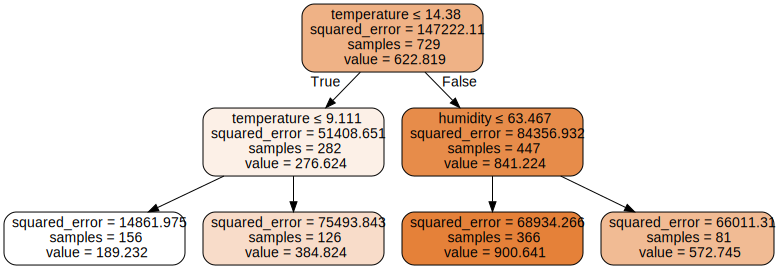

In [12]:
from IPython.display import Image
from sklearn import tree

# Crear un archivo DOT que representa el árbol de decisión (en este caso se devuelve como cadena)
dot_data = export_graphviz(regressor, out_file=None,
                     feature_names = ["temperature", "humidity", "windspeed"],
                     rounded = True, filled = True, special_characters=True)

# Generar el gráfico del árbol de decisión desde el archivo DOT
graph = graphviz.Source(dot_data)

# Mostrar el gráfico en Jupyter Notebook o en un archivo
#graph.view("arbol_de_decision")  # Esto guardará el gráfico en un archivo llamado "arbol_de_decision.pdf"
display(graph)

### Parametrización

Primero vamos a comprobar si nuestro rendimiento mejora al aumentar la profundidad evaluando con el propio conjunto de entrenamiento.

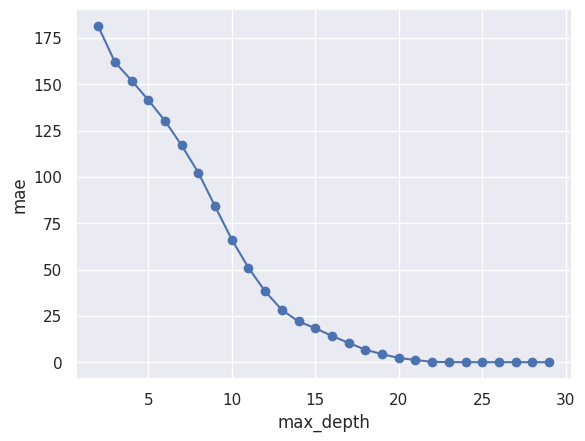

In [13]:
# Compute the max
mae = []
from sklearn.metrics import mean_absolute_error
for i in range(2, 30):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(bikes[['temperature', 'humidity']], bikes['count'])
    pred_values = regressor.predict(bikes[['temperature', 'humidity']])
    maev = mean_absolute_error(bikes['count'],pred_values)
    mae.append(maev)

# Plot mae
plt.plot(range(2,30), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Un árbol muy profundo aprenderá con muy poco error el valor del conjunto de entrenamiento. Pero el problema está en el overfitting, es decir, aprenderemos muy detalladamente las observaciones del conjunto de entrenamiento pero seremos muy poco flexibles en nuevas circunstancias.

Para evitar este overfitting, vamos a intentar realizar un proceso de validación cruzada, es decir, evaluar los parámetros ante diferentes subconjuntos de entrenamiento y prueba.



In [14]:
bikes = bikes.set_index("date")

In [15]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed','count']]


train = df.loc['2011-01-01':'2012-06-30']
test  = df.loc['2012-07-01':]
train.reset_index(drop = True, inplace = True)
df.loc['2011-01-01':'2012-06-30']

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0
...,...,...,...,...
2012-06-26,24.296565,42.145226,28.500501,1077.0
2012-06-27,27.607979,41.400771,23.088815,1077.0
2012-06-28,30.174329,44.890488,15.946777,921.0


Dividimos entre train y test

In [16]:
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]
train = df.loc['2011-01-01':'2012-06-30']
test  = df.loc['2012-07-01':]

# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)
train.head()

,temperature,humidity,windspeed,count
0,2.716070,45.715346,21.414957,120.0
1,2.896673,54.267219,15.136882,108.0
2,4.235654,45.697702,17.034578,82.0
3,3.112643,50.237349,10.091568,88.0
4,2.723918,49.144928,15.738204,148.0


Ejecutamos la validación cruzada

Min Value  :178.2506213566175 (5)


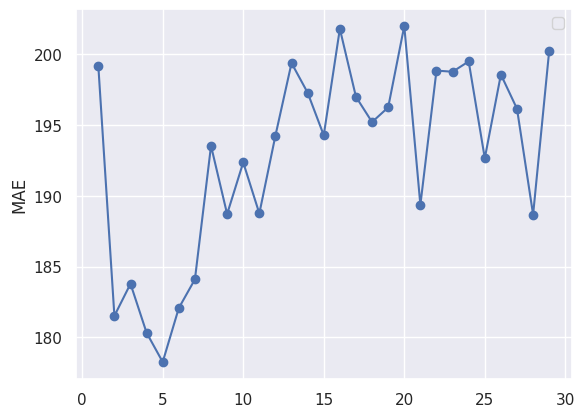

In [17]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = TimeSeriesSplit(n_splits = 10)

total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['count'], axis=1),
                            y = f_train['count'])
      y_pred = dt.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['count'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

plt.plot(range(1,len(total_scores)+1), total_scores,
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')

plt.legend()
plt.show()

### Ejecución

In [18]:
regressor = DecisionTreeRegressor(max_depth=6)
regressor.fit(X = train.drop(['count'], axis=1), y = train['count'])
y_pred = regressor.predict(X = test.drop(['count'], axis = 1))
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)


MAE 255.3613534696853


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


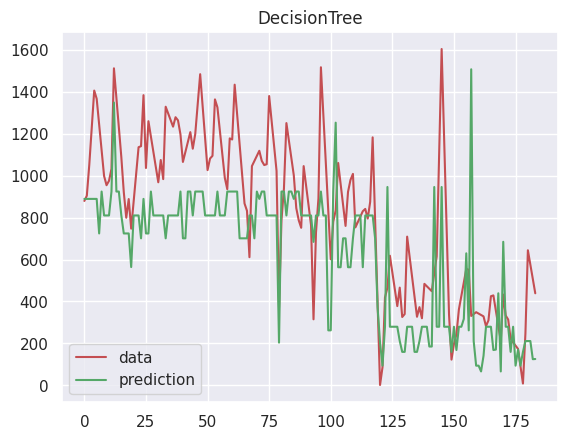

In [19]:
from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['count'].shape[0]))
plt.plot(xx, test['count'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

**Conclusiones**

* Los árboles de decisión pueden utilizarse para la regresión con una o varias variables.
* Cuanto más profundo sea el árbol, más compleja será su predicción.
* Un árbol de decisión demasiado profundo puede sobreajustar los datos, por lo que puede no ser
un buen predictor.
* La validación cruzada puede utilizarse para estimar el error y evitar el sobreajuste.
* La estimación del error puede utilizarse para comparar diferentes modelos de regresión
con el fin de elegir el más adecuado.


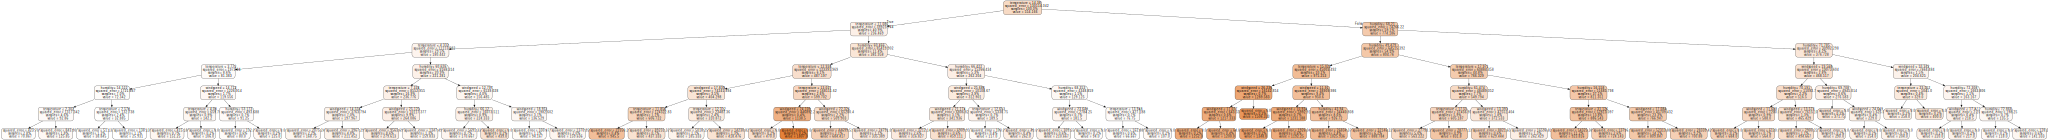

In [26]:
from IPython.display import Image
from sklearn import tree

from io import StringIO

dot_data = export_graphviz(regressor, proportion=True,
                     feature_names = ["temperature", "humidity", "windspeed"],
                     rounded = True, filled = True, special_characters=True)

graph = graphviz.Source(dot_data)
display(graph)